In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Grava o resultado em um arquivo texto denominado analise_tweets.txt
import sys
file_path = 'analise_tweets.txt'
sys.stdout = open(file_path, "w")

In [1]:
# Declaração das bibliotecas do pyspark
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType, TimestampType
from pyspark.sql.types import ArrayType, DoubleType, BooleanType
from pyspark.sql.functions import col,array_contains, sum
from pyspark.sql.functions import split, trim, concat, lit
from pyspark.sql.functions import to_date, to_timestamp, substring, when, asc, desc
import matplotlib.pyplot as plt

In [3]:
# Declaração da Sessão do spark
spark = SparkSession.builder.appName("DataFrame").getOrCreate()
sc = spark.sparkContext.setLogLevel('OFF')

In [4]:
# Criação de uma estrutura com os campos do arquivo
# Campos: id,tweet_text,tweet_date,sentiment,query_used
schema = StructType() \
    .add("id", StringType(), True) \
    .add("tweet_text", StringType(), True) \
    .add("tweet_date", StringType(), True) \
    .add("sentiment", StringType(), True) \
    .add("query_used", StringType(), True)

In [5]:
# Leitura do arquivo csv NoThemeTweets.csv
df = spark.read.format("csv") \
               .option("header", True) \
               .option("delimiter", ',') \
               .schema(schema) \
               .load("NoThemeTweets.csv")

In [6]:
# Conta a quantidade de linhas do dataframe df
qtd_tweet = df.count()
print(qtd_tweet)

785814


In [7]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- tweet_text: string (nullable = true)
 |-- tweet_date: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- query_used: string (nullable = true)



In [8]:
# Escreva a quantidade total de tweets lidos do dataframe
strMsg = "\nQuantidade Total de Tweets: " + str(qtd_tweet)
print(strMsg)


Quantidade Total de Tweets: 785814


In [9]:
# Realiza um tratamento dos dados lidos
# Formato do Timestamp do Tweet = Tue Aug 21 04:35:39 +0000 2018
df1=df.withColumn('tmp_Ano', when(col('tweet_date').substr(27, 4) == "2018", 2018)
                            .when(col('tweet_date').substr(27, 4) == "2019", 2019)
                            .when(col('tweet_date').substr(27, 4) == "2020", 2020)
                            .otherwise(0)
                 )  \
      .withColumn('tmp_Mes',  when(col('tweet_date').substr(5, 3) == "Jan", 1)
                             .when(col('tweet_date').substr(5, 3) == "Feb", 2)
                             .when(col('tweet_date').substr(5, 3) == "Mar", 3)
                             .when(col('tweet_date').substr(5, 3) == "Apr", 4)
                             .when(col('tweet_date').substr(5, 3) == "May", 5)
                             .when(col('tweet_date').substr(5, 3) == "Jun", 6)
                             .when(col('tweet_date').substr(5, 3) == "Jul", 7)
                             .when(col('tweet_date').substr(5, 3) == "Aug", 8)
                             .when(col('tweet_date').substr(5, 3) == "Sep", 9)
                             .when(col('tweet_date').substr(5, 3) == "Oct", 10)
                             .when(col('tweet_date').substr(5, 3) == "Nov", 11)
                             .when(col('tweet_date').substr(5, 3) == "Dec", 12)
                             .otherwise(0)
                 )

In [10]:
# Converte o Mês e o Ano para inteiro
df2 = df1.withColumn('Ano', col('tmp_Ano').cast("Integer"))  \
         .withColumn('Mês', col('tmp_Mes').cast("Integer"))

In [11]:
# Conta a quantidade de tweets e os agrupa por Mês e Ano
df3 = df2.groupBy(col('Ano'), col('Mês')) \
         .count()

In [12]:
# Seleciona os dados do dataframe df3
df4 = df3.select(col('Ano').alias("Ano da publicação do Tweet"), \
           col('Mês').alias("Mês da publicação do Tweet"), \
           col('count').alias("Quantidade de Tweets"))

In [13]:
# Filtra os anos que não foram possíveis de identificar nas linhas de cada tweet
df_tweet_sem_ano = df4.filter((df3.Ano == 0))

In [14]:
# Soma o campo "Quantidade de Tweets" do dataframe df_tweet_sem_ano
df5 = df_tweet_sem_ano.select(sum(col('Quantidade de Tweets')))
qtd_tweet_sem_ano = df5.collect()[0][0]

In [15]:
# Escreva a quantidade de tweets sem identificação de data
strMsg = "Quantidade de Tweets sem identificação de data: " + str(qtd_tweet_sem_ano)
print(strMsg)

Quantidade de Tweets sem identificação de data: 4014


In [16]:
print("\nQuantidade de Tweets publicados por Mês/Ano")
# Filtra os anos que não foram possíveis de identificar nas linhas do tweet
# e escreva o resultado na Tela
df4.filter( (df3.Ano != 0) ).show()


Quantidade de Tweets publicados por Mês/Ano
+--------------------------+--------------------------+--------------------+
|Ano da publicação do Tweet|Mês da publicação do Tweet|Quantidade de Tweets|
+--------------------------+--------------------------+--------------------+
|                      2018|                         8|              255921|
|                      2018|                         9|              474192|
|                      2018|                        10|               51687|
+--------------------------+--------------------------+--------------------+



In [57]:
data = df4.filter((df3.Ano != 0)).toPandas()
data

,Ano da publicação do Tweet,Mês da publicação do Tweet,Quantidade de Tweets
0,2018,8,255921
1,2018,9,474192
2,2018,10,51687


In [65]:
ano_mes = data["Mês da publicação do Tweet"].map(str) + "/" + data["Ano da publicação do Tweet"].map(str)
data['ano_mes'] = ano_mes
data

,Ano da publicação do Tweet,Mês da publicação do Tweet,Quantidade de Tweets,ano_mes
0,2018,8,255921,8/2018
1,2018,9,474192,9/2018
2,2018,10,51687,10/2018


In [66]:
quantidade = data['Quantidade de Tweets'].tolist()

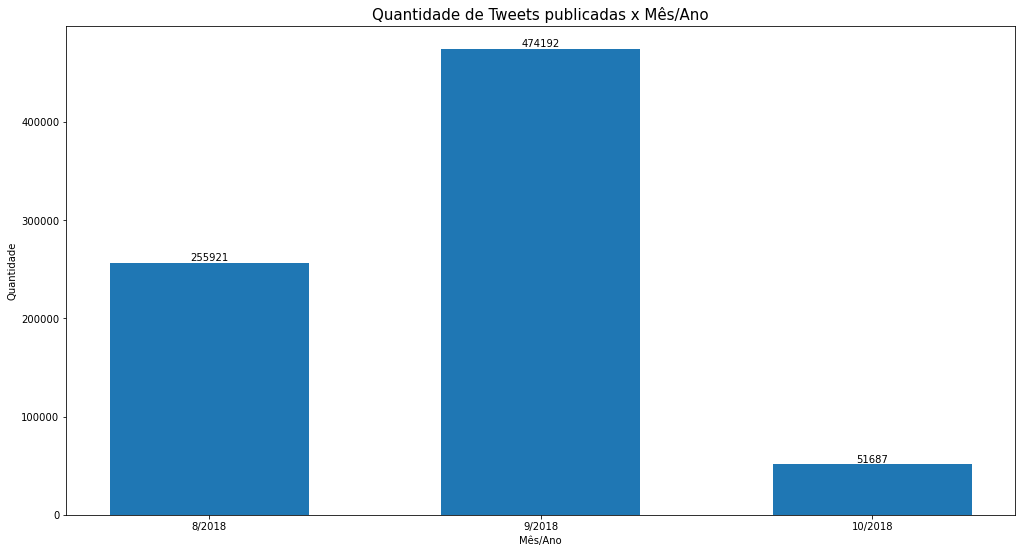

In [68]:
plt.figure(figsize=(17,9))
# Plot the bar graph
plot = plt.bar(ano_mes, quantidade, width=0.6)
 
# Add the data value on head of the bar
for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%d' % int(height), ha='center', va='bottom')
 
# Add labels and title
plt.title("Quantidade de Tweets publicadas x Mês/Ano", size=15)
plt.xlabel("Mês/Ano")
plt.ylabel("Quantidade")
 
# Display the graph on the screen
plt.show()

In [18]:
# Identifca as hashtag que estão no Trending topics000000000000000000
print("Hashtag Trending topics")
df6 = df.filter(col("tweet_text").contains("#"))
df7 = df6.withColumn("tmp_hashtag_1", split(col("tweet_text"), "#").getItem(0)).withColumn("tmp_hashtag_2", split(col("tweet_text"), "#").getItem(1))
df8 = df7.select(col('tmp_hashtag_2'))
df9 = df8.withColumn("hashtag", split(col("tmp_hashtag_2"), " ").getItem(0)).withColumn("col_2", split(col("tmp_hashtag_2"), " ").getItem(1))
df10 = df9.select(trim(col('hashtag')).alias("hashtag"))
df11 = df10.filter(col('hashtag') != "")
df12 = df11.groupBy(col('hashtag')).count()
df13 = df12.orderBy(col('count').desc())
df13.select(concat(lit("#"), col('hashtag')).alias("#Hashtag"), col('count').alias("Quantidade")).show(10)

Hashtag Trending topics
+--------------------+----------+
|            #Hashtag|Quantidade|
+--------------------+----------+
|                #MPN|       578|
|         #AFazenda10|       172|
|                #20:|       171|
|     #TheVoiceBrasil|       165|
|       #MasterChefBR|       142|
|#BTSLoveYourselfTour|       128|
|         #LojaBolada|       123|
|               #VMAs|       121|
|     #OrgulhoEPaixão|       118|
|         #SegundoSol|       117|
+--------------------+----------+
only showing top 10 rows



In [24]:
data = df13.limit(10).toPandas()
data

,hashtag,count
0,MPN,578
1,AFazenda10,172
2,20:,171
3,TheVoiceBrasil,165
4,MasterChefBR,142
5,BTSLoveYourselfTour,128
6,LojaBolada,123
7,VMAs,121
8,OrgulhoEPaixão,118
9,SegundoSol,117


In [20]:
import matplotlib.pyplot as plt

In [21]:
hashtag = data['hashtag'].tolist()
print(hashtag)

['MPN', 'AFazenda10', '20:', 'TheVoiceBrasil', 'MasterChefBR', 'BTSLoveYourselfTour', 'LojaBolada', 'VMAs', 'OrgulhoEPaixão', 'SegundoSol']


In [22]:
quantidade = data['count'].tolist()
print(quantidade)

[578, 172, 171, 165, 142, 128, 123, 121, 118, 117]


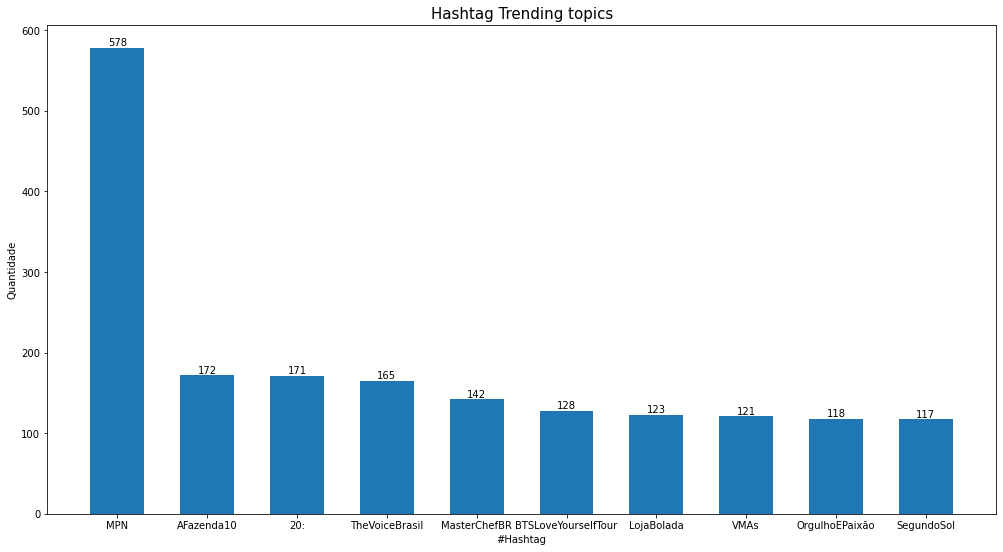

In [113]:
plt.figure(figsize=(17,9))
# Plot the bar graph
plot = plt.bar(hashtag, quantidade, width=0.6)
 
# Add the data value on head of the bar
for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%d' % int(height), ha='center', va='bottom')
 
# Add labels and title
plt.title("Hashtag Trending topics", size=15)
plt.xlabel("#Hashtag")
plt.ylabel("Quantidade")
 
# Display the graph on the screen
plt.show()

In [ ]:
l = [('Alice', 1)]

In [ ]:
spark.createDataFrame(l).collect()

In [ ]:
spark.createDataFrame(l, ['name', 'age']).collect()

In [ ]:
df.limit(10).toPandas()

In [1]:
print("ola")

ola


In [ ]:
print("ola")